### Modelling of 2020 trips and recovery rate (slope)

1. Create a dataset for MSOA vs. Local Authority
2. Identify outliers
3. Decompose recovery by LA/MSOA and estimate Spatial Resilience Measure
4. Plotting of Spatial Resilience Measure

In [9]:
# Import modules

import pandas as pd
import datetime
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib import colors

from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import r2_score

import math
from math import sqrt
import numpy as np
import random
#import mapclassify
from shapely.wkt import loads


random.seed(42)
sns.set_theme(style="white")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

In [10]:
# Read in csv data
pt_msoaest = pd.read_csv('../output_data/pt_msoaest.csv')
google_mobility = pd.read_csv('../data/google_activity_by_London_Borough.csv') # to sanity check recovery rate


# Shape Files
boroughs = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')

                         
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')


### Recovery Rate Data Frame

This section creates a dataframe to estimate weekly recovery rate, and categorises MSOAs by region.

In [11]:
# Convert week_beg to datetime to allow for plotting by time
pt_msoaest['week_beg'] = pd.to_datetime(pt_msoaest['week_beg'])
pt_msoaest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204682 entries, 0 to 204681
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   year                  204682 non-null  int64         
 1   week                  204682 non-null  int64         
 2   week_beg              204682 non-null  datetime64[ns]
 3   msoa_code             204682 non-null  object        
 4   msoa_name             204682 non-null  object        
 5   la_code               204682 non-null  object        
 6   la_name               204682 non-null  object        
 7   geometry              204682 non-null  object        
 8   origin_trips          204682 non-null  float64       
 9   origin_mth            204682 non-null  float64       
 10  origin_fss            204682 non-null  float64       
 11  origin_rail           204682 non-null  float64       
 12  origin_bus            204682 non-null  float64       
 13 

In [12]:
# Set parameters of dates for analysis -- when restrictions were lifted to when new restrictions were introduced
start_wk = 23 # beginning of recovery based on origin_trips count
start_wkbeg = '2020-06-08'
end_wk = 37 # recovery peaks
end_wkbeg = '2020-09-07'

In [13]:
# Calculate the percent difference between actual trips and predicted trips (Recovery Ratio, RR)
df = pt_msoaest
#df = df[(df['week_beg']>=start_wkbeg)]#&(df['week_beg']<='09/14/2020')]

# Calculate Origin Trips by Estimate2
df['delta'] = df['origin_trips']-df['estimate_origin']
df['pct_diff'] = (df['origin_trips']/df['estimate_origin'])*100 # just to get it into whole numbers
df['log_pctdiff'] = np.log(df['pct_diff'])
#df = df.merge(days_map, left_on = 'week_beg', right_on = 'date')

pt_msoaest = df

C:\Users\TBD\.conda\envs\dissertation\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
# Map by region, as it will be valuable to see pct_diff by region to identify trends.

df = pt_msoaest
mapping_region = {}
mapping_subregion = {}


for i in ['Enfield', 'Waltham Forest', 'Redbridge', 'Barking and Dagenham','Havering','Greenwich','Bexley',
         'Bromley','Croydon','Sutton','Merton','Kingston upon Thames', 'Richmond upon Thames','Hounslow','Ealing',
         'Hillingdon','Brent','Harrow','Barnet']:
    mapping_region[i] = 'Outer'
for i in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham',
         'Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping_region[i] = 'Inner'


for i in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping_subregion[i]='Outer East and North East'
for i in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping_subregion[i]='Inner East'
for i in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping_subregion[i]='Outer South'
for i in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping_subregion[i]='Inner West'
for i in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping_subregion[i]='Outer West and North West'
    
    
df['region'] = df.la_name.apply(lambda x: mapping_region[x])
df['subregion'] = df.la_name.apply(lambda x: mapping_subregion[x])
pt_msoaest = df

In [15]:
# Table of mapping to include in appendix
df[['region', 'subregion', 'la_name']].drop_duplicates()

,region,subregion,la_name
0,Inner,Inner West,City of London
240,Outer,Outer East and North East,Barking and Dagenham
1680,Outer,Outer West and North West,Barnet
5760,Outer,Outer East and North East,Bexley
7918,Outer,Outer West and North West,Brent
12718,Outer,Outer South,Bromley
16318,Inner,Inner West,Camden
20600,Outer,Outer South,Croydon
23479,Outer,Outer West and North West,Ealing
26838,Outer,Outer East and North East,Enfield


In [16]:
## Sanity check against google mobility data

google_mobility['date'] = pd.to_datetime(google_mobility['date'])

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
#df = df[(df['week_beg']=='09/14/2020')]
df = df.groupby(['year', 'week', 'week_beg','la_code', 'la_name'])['origin_trips', 'estimate_origin', 'residuals'].agg('sum').reset_index()

# Calculate Origin Trips by Estimate2
df['delta'] = df['origin_trips']-df['estimate_origin']
df['pct_diff'] = ((df['origin_trips']-df['estimate_origin'])/df['estimate_origin'])*100
df['log_pctdiff'] = np.log(df['pct_diff'])
df = df.merge(google_mobility, left_on = ['week_beg', 'la_code'], right_on = ['date', 'area_code'])

pt_laest = df
#pt_laest.head()

C:\Users\TBD\.conda\envs\dissertation\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\TBD\.conda\envs\dissertation\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


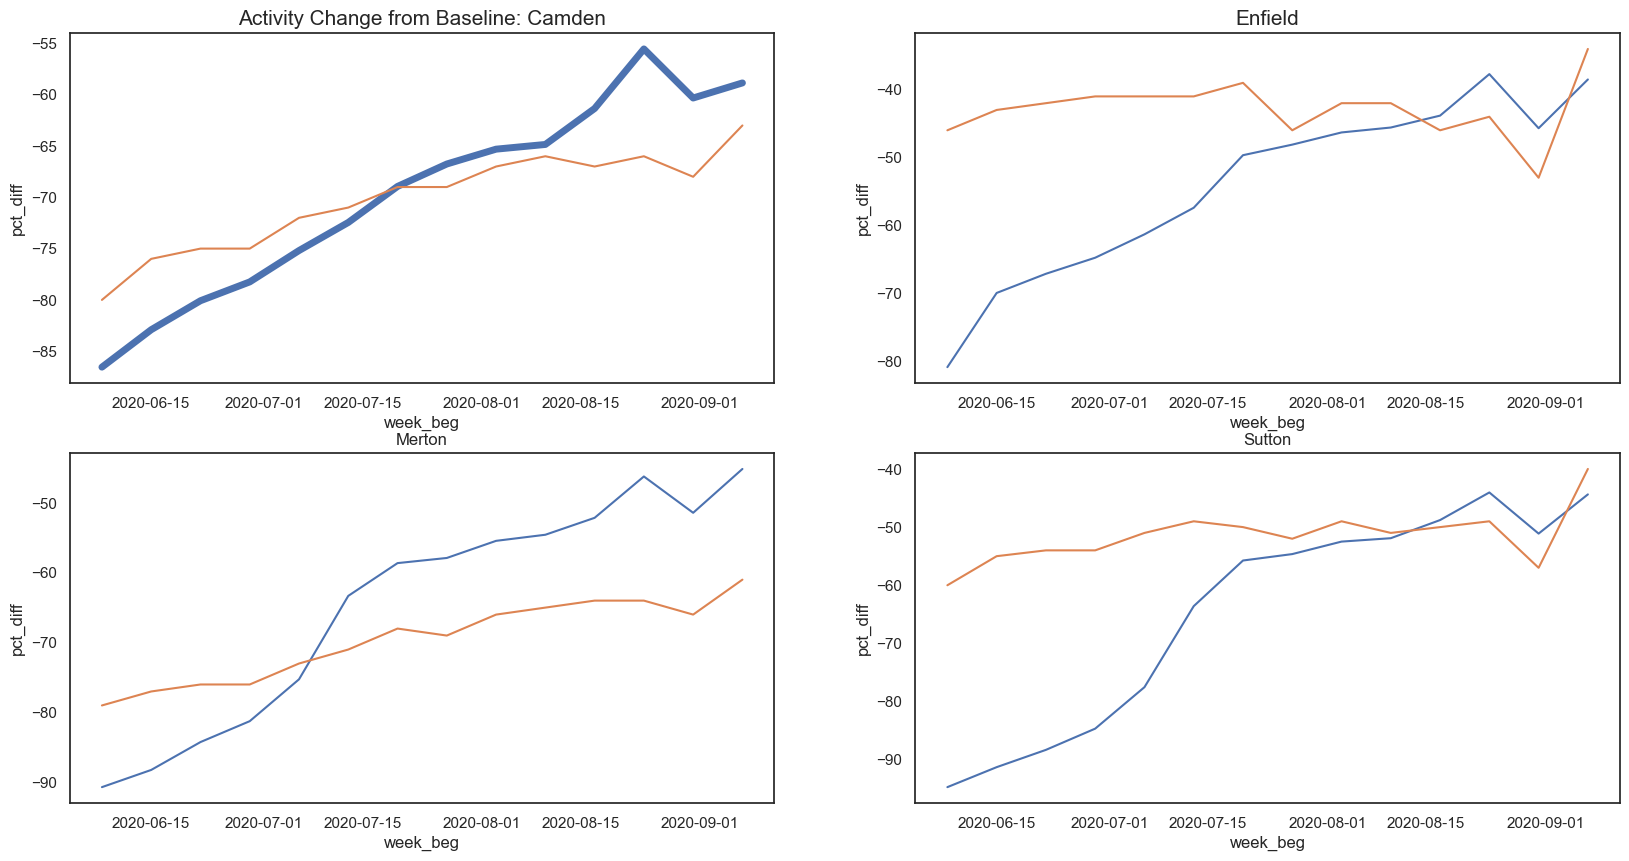

In [17]:
# Sanity checking against 4 major boroughs for this analysis
df = pt_laest

fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=False, sharey=False)
p = sns.lineplot(x='week_beg', y='pct_diff', data = df[df['la_name']=='Camden'], legend = False, ax=ax[0,0],linewidth=5)
p = sns.lineplot(x='week_beg', y='transit_stations_percent_change_from_baseline', data = df[df['la_name']=='Camden'], legend = False, ax=ax[0,0])

q = sns.lineplot(x='week_beg', y='pct_diff', data = df[df['la_name']=='Enfield'], legend = False, ax=ax[0,1])
q = sns.lineplot(x='week_beg', y='transit_stations_percent_change_from_baseline', data = df[df['la_name']=='Enfield'], legend = False, ax=ax[0,1])

r = sns.lineplot(x='week_beg', y='pct_diff', data = df[df['la_name']=='Merton'], legend = False, ax=ax[1,0])
r = sns.lineplot(x='week_beg', y='transit_stations_percent_change_from_baseline', data = df[df['la_name']=='Hillingdon'], legend = False, ax=ax[1,0])

s = sns.lineplot(x='week_beg', y='pct_diff', data = df[df['la_name']=='Sutton'], legend = True, ax=ax[1,1])
s = sns.lineplot(x='week_beg', y='transit_stations_percent_change_from_baseline', data = df[df['la_name']=='Bromley'], legend = True, ax=ax[1,1])

p.set_title("Activity Change from Baseline: Camden", fontsize = 15)
q.set_title("Enfield", fontsize = 15)
r.set_title("Merton", fontsize = 12)
s.set_title("Sutton", fontsize = 12)
plt.show()

In [18]:
# Calculate weeks from the beginning of the lockdown, this is important for the slope estimates (cannot be against a datetime object)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df['week_beg'].unique()
df = pd.DataFrame(df)
df.rename(columns = {0:'week_beg'}, inplace = True)

df['weeks'] = 0
df = df.sort_values(by=['week_beg'])

# For loop to calculate number of days in the analysis
for j in range(0, len(df)):
    if (j==0):
        df.iloc[j, len(df.columns)-1] = 0
    else:
        df.iloc[j, len(df.columns)-1] = df.iloc[j-1, len(df.columns)-1] + 1

weeks_map = df
#weeks_map

#### Identify Outliers
Utilising the Tukey Test to identify outliers, visually confirming which MSOAs should be excluded from the analysis. Observing raw data of trip recovery and the "percent difference" by region to validate the paper's findings that the Outer South has the fastest recovery rate. 

In [19]:
# Tukey Outliers

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]

IQR_s = df['pct_diff'].quantile(0.75) - df['pct_diff'].quantile(0.25)
low_s = df['pct_diff'].quantile(0.25) - 1.5*IQR_s
high_s = df['pct_diff'].quantile(0.75) + 1.5*IQR_s

outlier_low_s = df[df['pct_diff'] < low_s]
outlier_high_s = df[df['pct_diff'] > high_s]

outliers = pd.concat([outlier_low_s, outlier_high_s])
msoa_outliers = outliers[['msoa_name']].drop_duplicates()
#msoa_outliers = msoa_outliers.reset_index()
msoa_outliers = list(msoa_outliers['msoa_name'])
msoa_outliers

['Hounslow 025',
 'Redbridge 026',
 'Croydon 016',
 'Croydon 024',
 'Tower Hamlets 020',
 'Hackney 001',
 'Croydon 023',
 'Ealing 039',
 'Lambeth 016',
 'Bromley 001',
 'Hammersmith and Fulham 002']

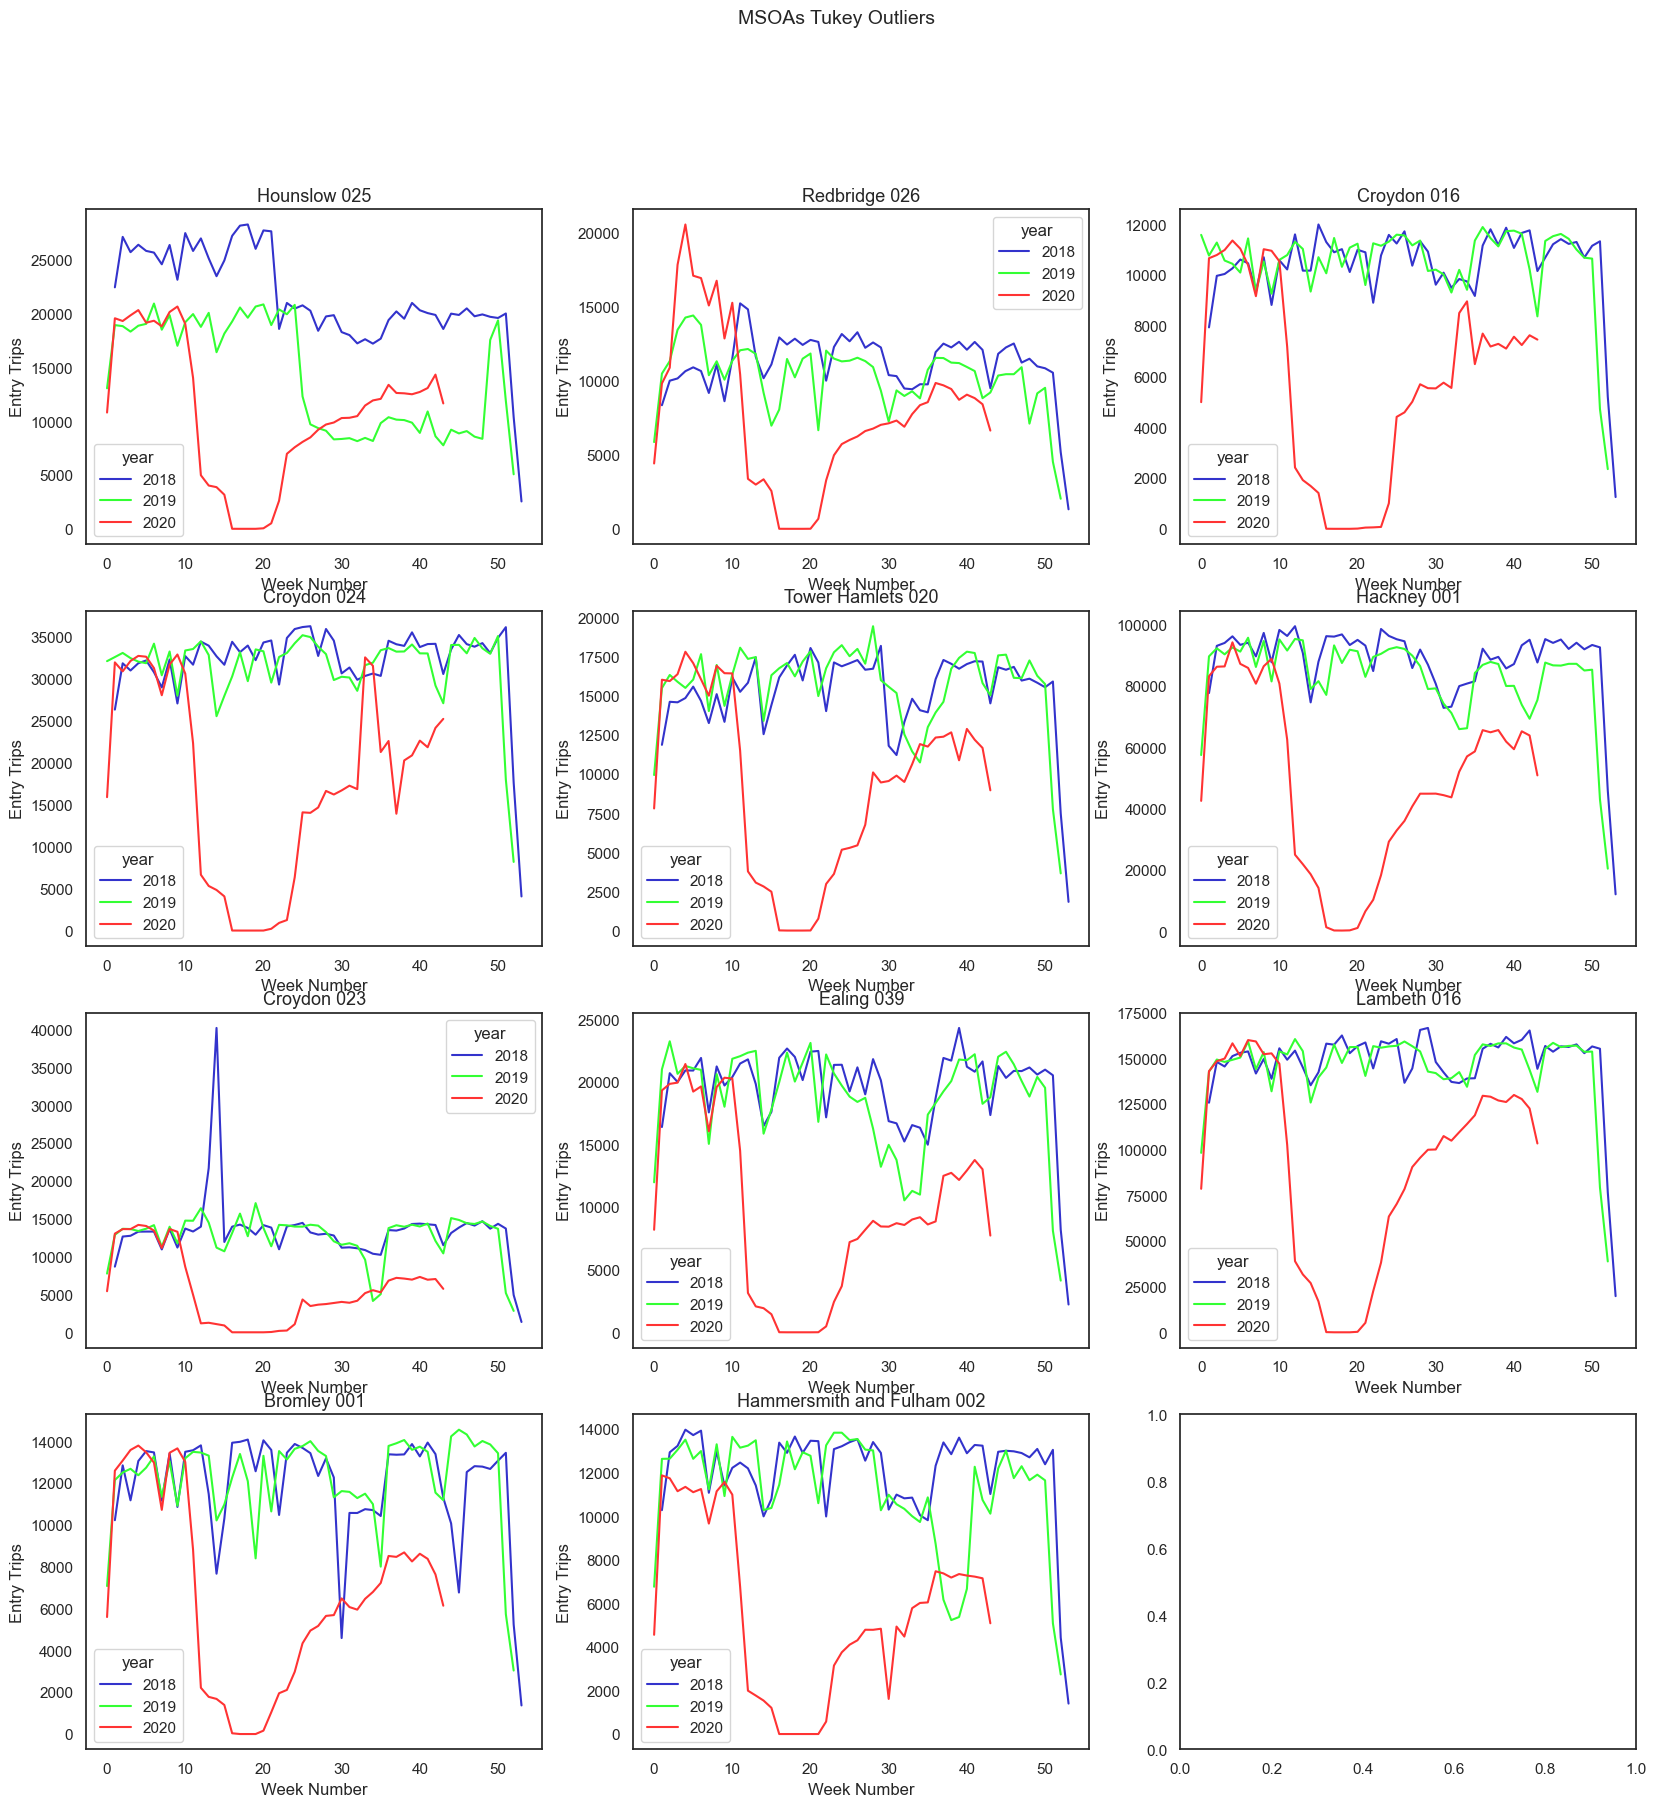

In [20]:
# Analysing all MSOAs to see if the outliers are reasonable.

f, ax = plt.subplots(4,3, figsize=(20, 20))
#f.tight_layout()
df = pt_msoaest

tfl_cmap = colors.ListedColormap(['#3333CC', '#33FF33', '#FF3333'])

k = 0

for i in range(0, 4):
    for j in range(0, 3):
        if k <= (len(msoa_outliers)-1):
            p = sns.lineplot(x='week',
                         y='origin_trips',
                         data = df[(df['msoa_name'] == msoa_outliers[k])&(df['year']>=2018)],
                         hue = 'year',
                         legend = True,
                         alpha=1,
                         palette = tfl_cmap,
                         ax = ax[i,j])
            p.set_title(f"{msoa_outliers[k]}", fontsize = 13)
            p.set_ylabel('Entry Trips')
            p.set_xlabel('Week Number')
            #sns.histplot(x=plt_cols[k], data = df, ax=ax[i,j], color = 'blue')
            k = k+1
            
f.suptitle('MSOAs Tukey Outliers', fontsize = 14)
plt.show()
plt.savefig('../figures/tukeyoutliers.png')

In [21]:
# Selected Outliers for this analysis
msoa_outliers_final = ['Hounslow 025']

<Figure size 640x480 with 0 Axes>

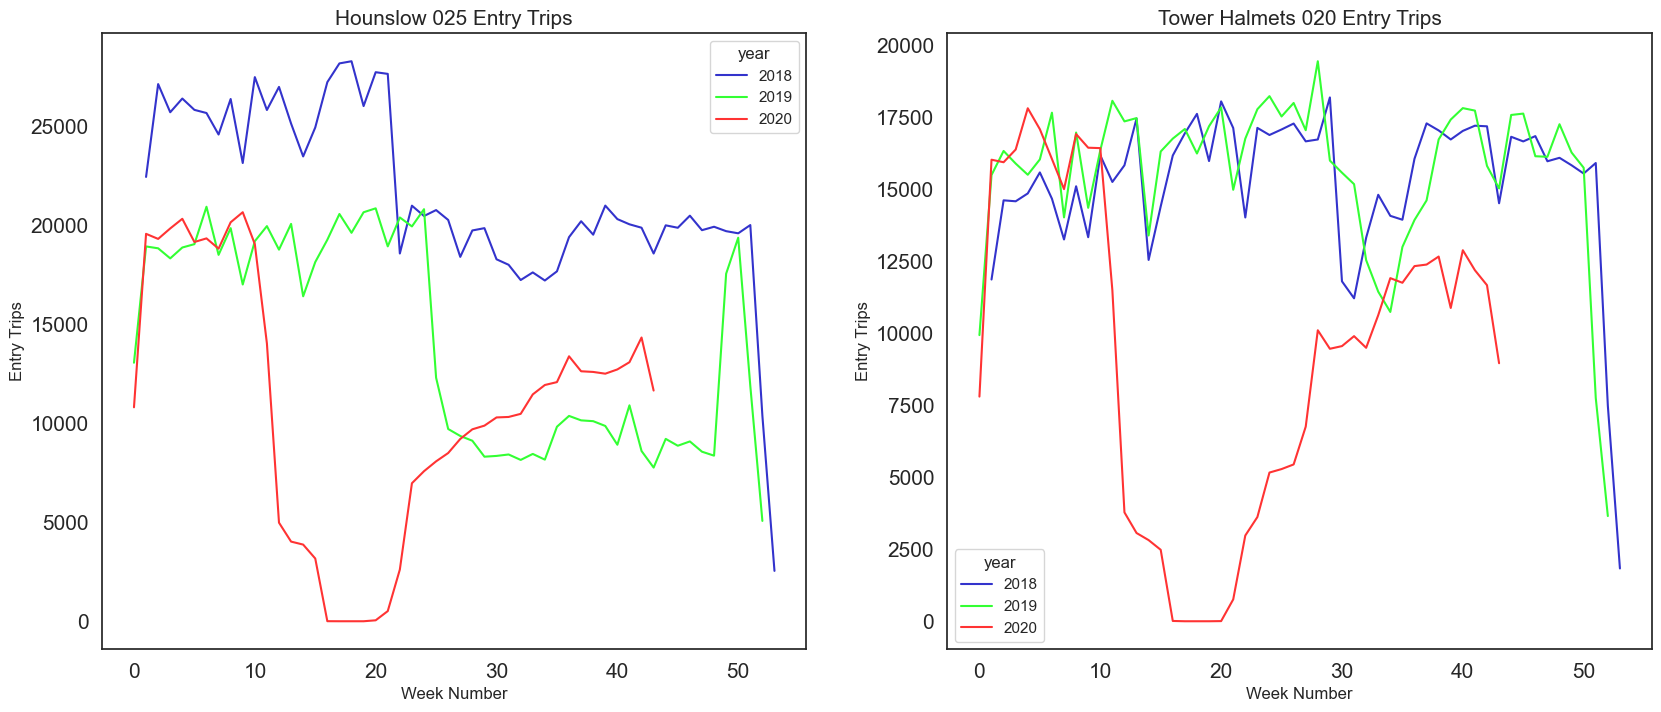

In [22]:
# Outliers Example for paper

sns.set_context('notebook')
#sns.set_theme(style="whitegrid")
#sns.set(rc = {'axes.labelsize':15})


f, ax = plt.subplots(1,2, figsize=(20, 8))

tfl_cmap = colors.ListedColormap(['#3333CC', '#33FF33', '#FF3333'])

df = pt_msoaest

p = sns.lineplot(x='week', y='origin_trips', data = df[(df['msoa_name'] == 'Hounslow 025')&(df['year']>=2018)], hue = 'year',
                legend = True,
                alpha=1,
                palette = tfl_cmap,
                ax = ax[0])
q = sns.lineplot(x='week', y='origin_trips', data = df[(df['msoa_name'] == 'Tower Hamlets 020')&(df['year']>=2018)], hue = 'year',
                legend = True,
                alpha=1,
                palette = tfl_cmap,
                ax = ax[1])

p.set_title("Hounslow 025 Entry Trips", fontsize = 15)
q.set_title("Tower Halmets 020 Entry Trips", fontsize = 15)

p.set_ylabel("Entry Trips")
p.set_xlabel("Week Number")
q.set_ylabel("Entry Trips")
q.set_xlabel("Week Number")

for i in range(0,2):
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        label.set_fontsize(15)
    
plt.show()
plt.savefig('../figures/tukeyoutliers_sample.png')

<Figure size 640x480 with 0 Axes>

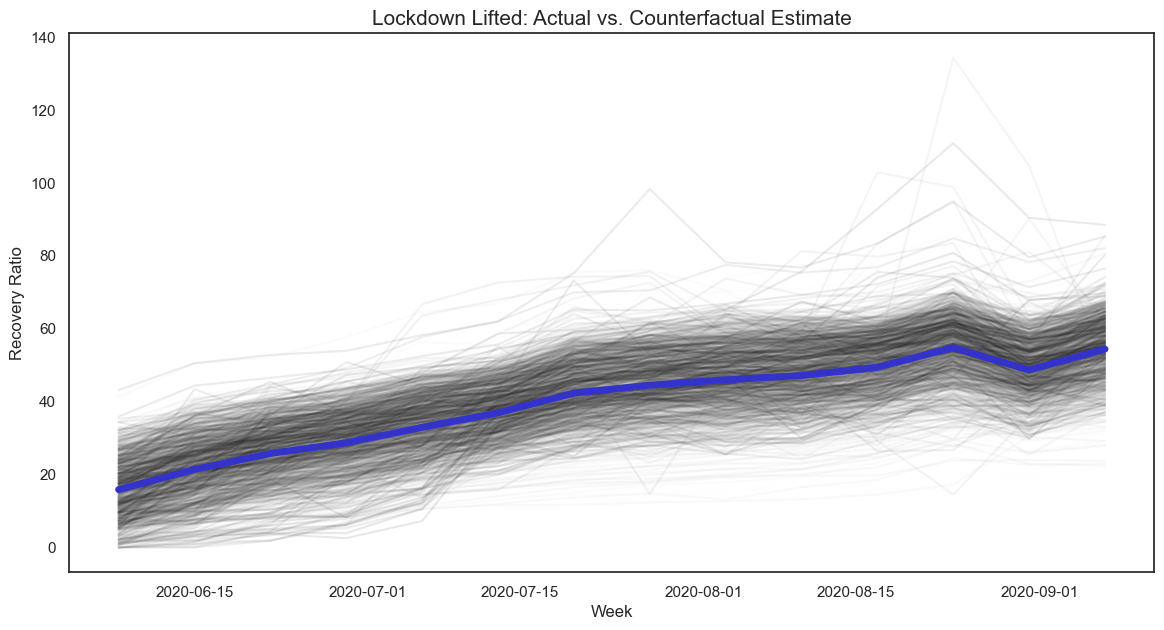

In [23]:
sns.set_context('notebook')

fig, ax = plt.subplots(1, 1, figsize=(14, 7), sharex=False, sharey=False)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers_final)]
df2 = df.groupby('week_beg')['pct_diff'].agg('mean').reset_index()


p = sns.lineplot(x='week_beg', y='pct_diff', data = df, hue='msoa_name', legend = False, palette = 'Greys', alpha=0.09)#, ax=ax[0])
q = sns.lineplot(x='week_beg', y='pct_diff', data = df2, legend = False, color = '#3333CC', dashes = True, linewidth=5)#, size = 500)#, ax=ax[0])
#ax.axhline(high_s, color='r', ls='--')
#ax.axhline(low_s, color='r', ls='--')

p.set_title("Lockdown Lifted: Actual vs. Counterfactual Estimate", fontsize = 15)
plt.ylabel("Recovery Ratio")
plt.xlabel("Week")
plt.show()
plt.savefig('../figures/percentestimate_trend.png')

In [24]:
# Observing MSOAs that go beyond 100%, but not considered an official outlier
df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers_final)]
df[df['pct_diff']>100]

,year,week,week_beg,msoa_code,msoa_name,la_code,la_name,geometry,origin_trips,origin_mth,...,estimate_origin_mth,estimate_origin_fss,residuals,residuals_mth,residuals_fss,delta,pct_diff,log_pctdiff,region,subregion
194413,2020,33,2020-08-17,E02000217,Croydon 024,E09000008,Croydon,"POLYGON ((531803.499960717 166037.1949205152, ...","32,560.00","20,923.00",...,"18,746.00","12,884.00",-930.00,"-2,177.00","1,247.00",930.00,102.94,4.63,Outer,Outer South
195394,2020,34,2020-08-24,E02000216,Croydon 023,E09000008,Croydon,"POLYGON ((534857.812959885 165834.8279201637, ...","5,565.00","3,196.00",...,"2,468.00","1,675.00","-1,422.00",-728.00,-694.00,"1,422.00",134.32,4.90,Outer,Outer South
195775,2020,34,2020-08-24,E02000883,Tower Hamlets 020,E09000030,Tower Hamlets,"POLYGON ((537751.83695885 181672.9879157364, 5...","11,925.00","6,763.00",...,"6,263.00","4,487.00","-1,175.00",-500.00,-675.00,"1,175.00",110.93,4.71,Inner,Inner East
196376,2020,35,2020-08-31,E02000216,Croydon 023,E09000008,Croydon,"POLYGON ((534857.812959885 165834.8279201637, ...","5,285.00","3,184.00",...,"3,539.00","1,508.00",-238.00,355.00,-593.00,238.00,104.72,4.65,Outer,Outer South


C:\Users\TBD\.conda\envs\dissertation\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


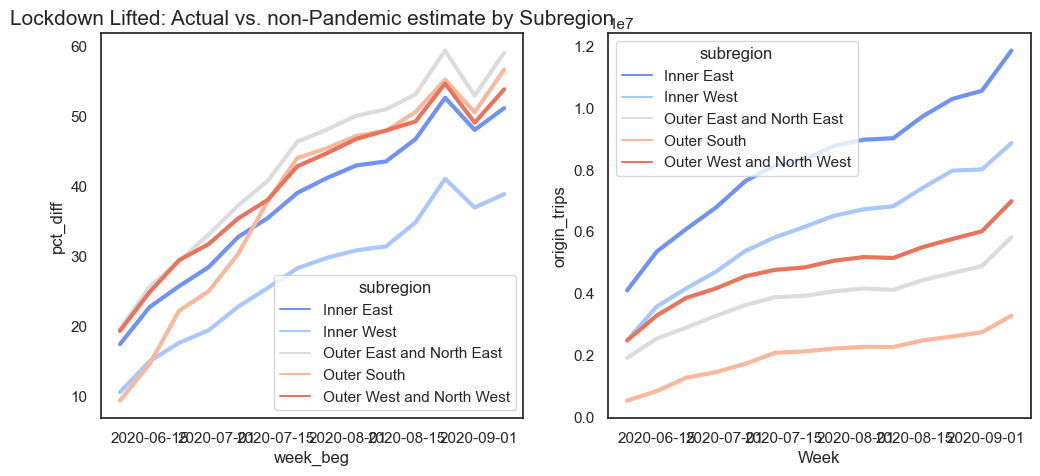

In [26]:
# Observing estimate by Subregion, this allows us to see the rapid recovery in Outer South compared to the rest 
sns.set_context('notebook')

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers_final)]
df = df.groupby(['week_beg', 'subregion'])['origin_trips', 'estimate_origin', 'origin_rail', 'origin_bus'].agg('sum').reset_index()
df['pct_diff'] = (df['origin_trips']/df['estimate_origin'])*100


p = sns.lineplot(x='week_beg', y='pct_diff', data = df, hue='subregion', legend = True, palette = 'coolwarm', ci = None, linewidth = 3, ax=ax[0])
q = sns.lineplot(x='week_beg', y='origin_trips', data = df, hue='subregion', legend = True, palette = 'coolwarm', ci = None, linewidth = 3, ax=ax[1])
p.set_title("Lockdown Lifted: Actual vs. non-Pandemic estimate by Subregion", fontsize = 15)
#plt.ylabel("Percent actual of estimate")
plt.xlabel("Week")
plt.show()

#### Decompose Trend and estimate Spatial Resilience Measure
The following section walks through the three step process to estimate the Spatial Resilience Measure: (1) Plot the Recovery Ratio, RR (2) Decompose the trend of this ratio (3) Fit a regression line and capture the slope of this line.

Examples for Camden 001 and Hackney 015 are provided, along with a for loop to estimate the slope for each individual MSOA.

[ 3.62733666 20.34449841]


<Figure size 640x480 with 0 Axes>

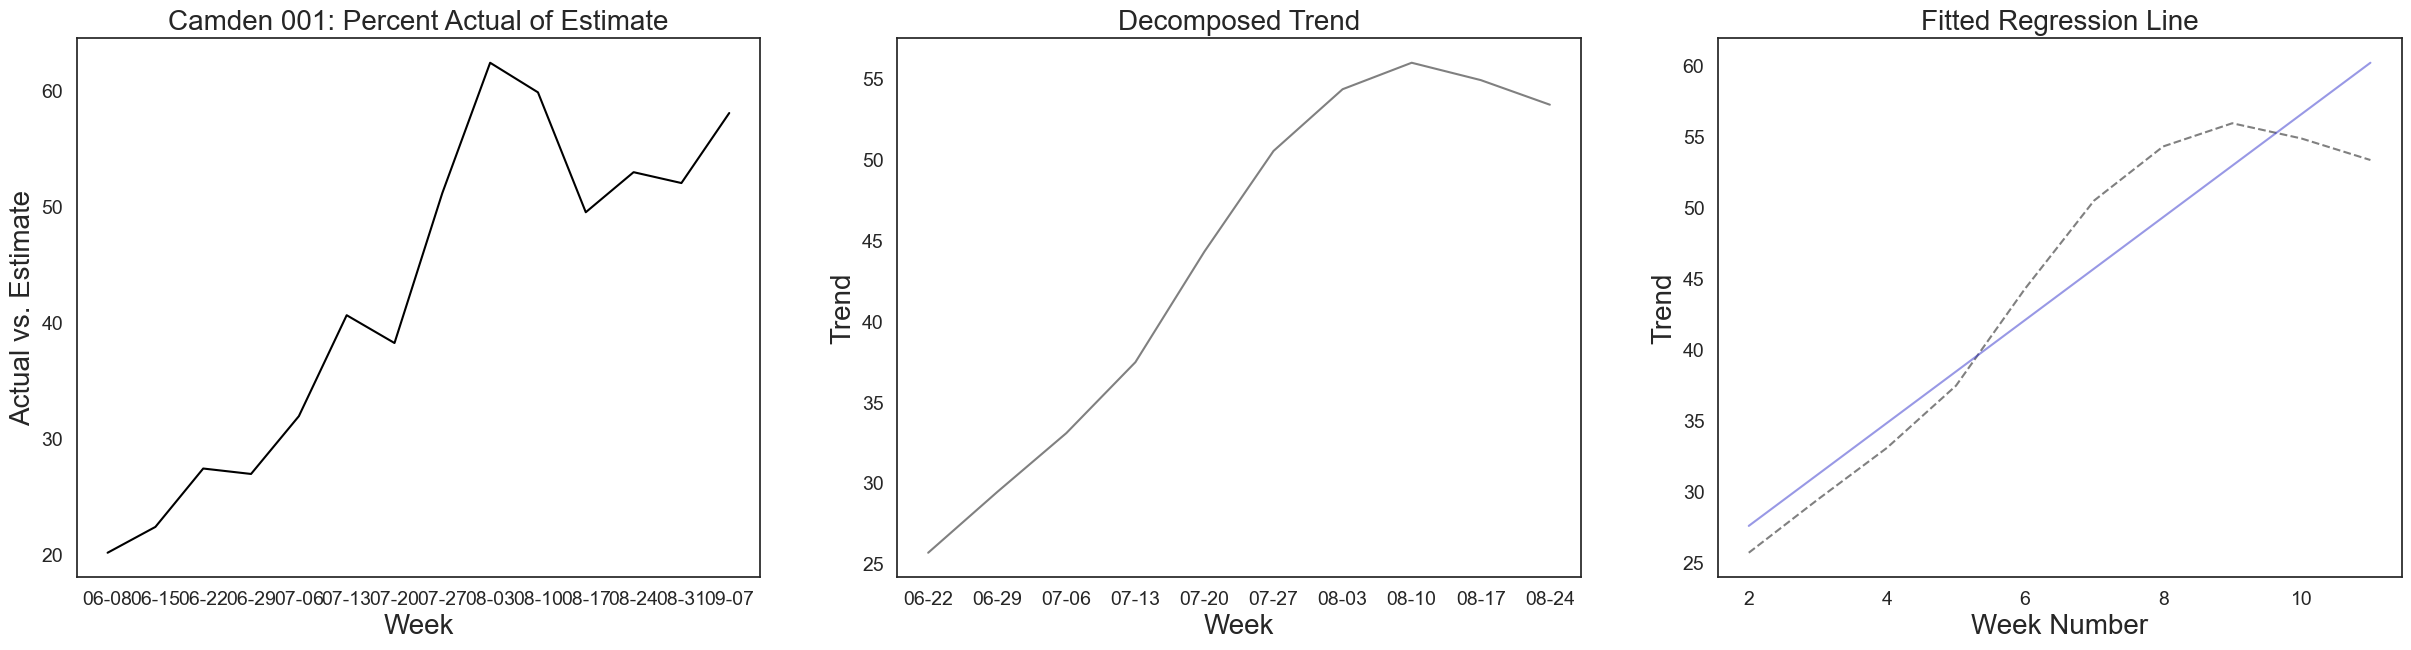

In [31]:
# Creating an example of plots for Camden 001 that show the estimated line fit and corresponding slope
sns.set_context('notebook')

fig, ax = plt.subplots(1, 3, figsize=(30, 7), sharex=False, sharey=False)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers_final)]
df = df[df['msoa_name']=='Camden 001']

df_sample = df[['week_beg', 'pct_diff']]
df_sample = df_sample.set_index('week_beg')
decomposition_sample = sm.tsa.seasonal_decompose(df_sample, model = 'additive', period = 4)
df_sample = df_sample.reset_index()
df_sample['week_beg'] = df_sample['week_beg'].dt.strftime('%m-%d')

df_sampletrend = decomposition_sample.trend
df_sampletrend = pd.DataFrame(decomposition_sample.trend[2:len(df_sample)-2])
df_sampletrend = df_sampletrend.reset_index()
df_sampletrend = df_sampletrend.merge(weeks_map, how = 'left', left_on = 'week_beg', right_on = 'week_beg')
df_sampletrend['week_beg'] = df_sampletrend['week_beg'].dt.strftime('%m-%d')
trend = np.array(df_sampletrend['trend'])
weeks = np.array(df_sampletrend['weeks'])

coefficients = np.polyfit(weeks, trend, 1)
print(coefficients)
poly = np.poly1d(coefficients)

new_x = np.linspace(weeks[0], weeks[-1])
new_y = poly(new_x)

df_regression = pd.DataFrame(new_x, new_y)
df_regression = df_regression.reset_index()
df_regression = df_regression.rename({0:'weeks'}, axis=1)

#correlation_matrix = np.corrcoef(new_y, trend)
#correlation_xy = correlation_matrix[0,1]
#r_squared = correlation_xy**2
#r2_score(trend, df_regression['index'])
#print(r_squared)

p = sns.lineplot(x='week_beg', y='pct_diff', data = df_sample, color = 'black', legend = False, ax=ax[0])#, palette = 'light:b', alpha=0.5)#, ax=ax[0])
q = sns.lineplot(x='week_beg', y='trend', data = df_sampletrend, color = 'grey', legend = False, ax=ax[1])
r = sns.lineplot(x='weeks', y='trend', data = df_sampletrend, color = 'grey', legend = False, ls='--', ax=ax[2])
s = sns.lineplot(x='weeks', y='index', data = df_regression, color = '#3333CC', legend = False, alpha = 0.5, ax=ax[2])

#fig.suptitle('Sample of how Resilience Measure is calculated', fontsize=15)

p.set_title("Camden 001: Percent Actual of Estimate", fontsize = 20)
p.set_ylabel("Actual vs. Estimate", fontsize = 20)
p.set_xlabel("Week", fontsize = 20)


q.set_title("Decomposed Trend", fontsize = 20)
q.set_ylabel("Trend", fontsize = 20)
q.set_xlabel("Week", fontsize = 20)

r.set_title("Fitted Regression Line", fontsize = 20)
r.set_ylabel("Trend", fontsize = 20)
r.set_xlabel("Week Number", fontsize = 20)

for i in range(0,3):
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        label.set_fontsize(14)
        
plt.show()
plt.savefig('../figures/camden_sample.png')

[ 1.38261361 48.79197278]


<Figure size 640x480 with 0 Axes>

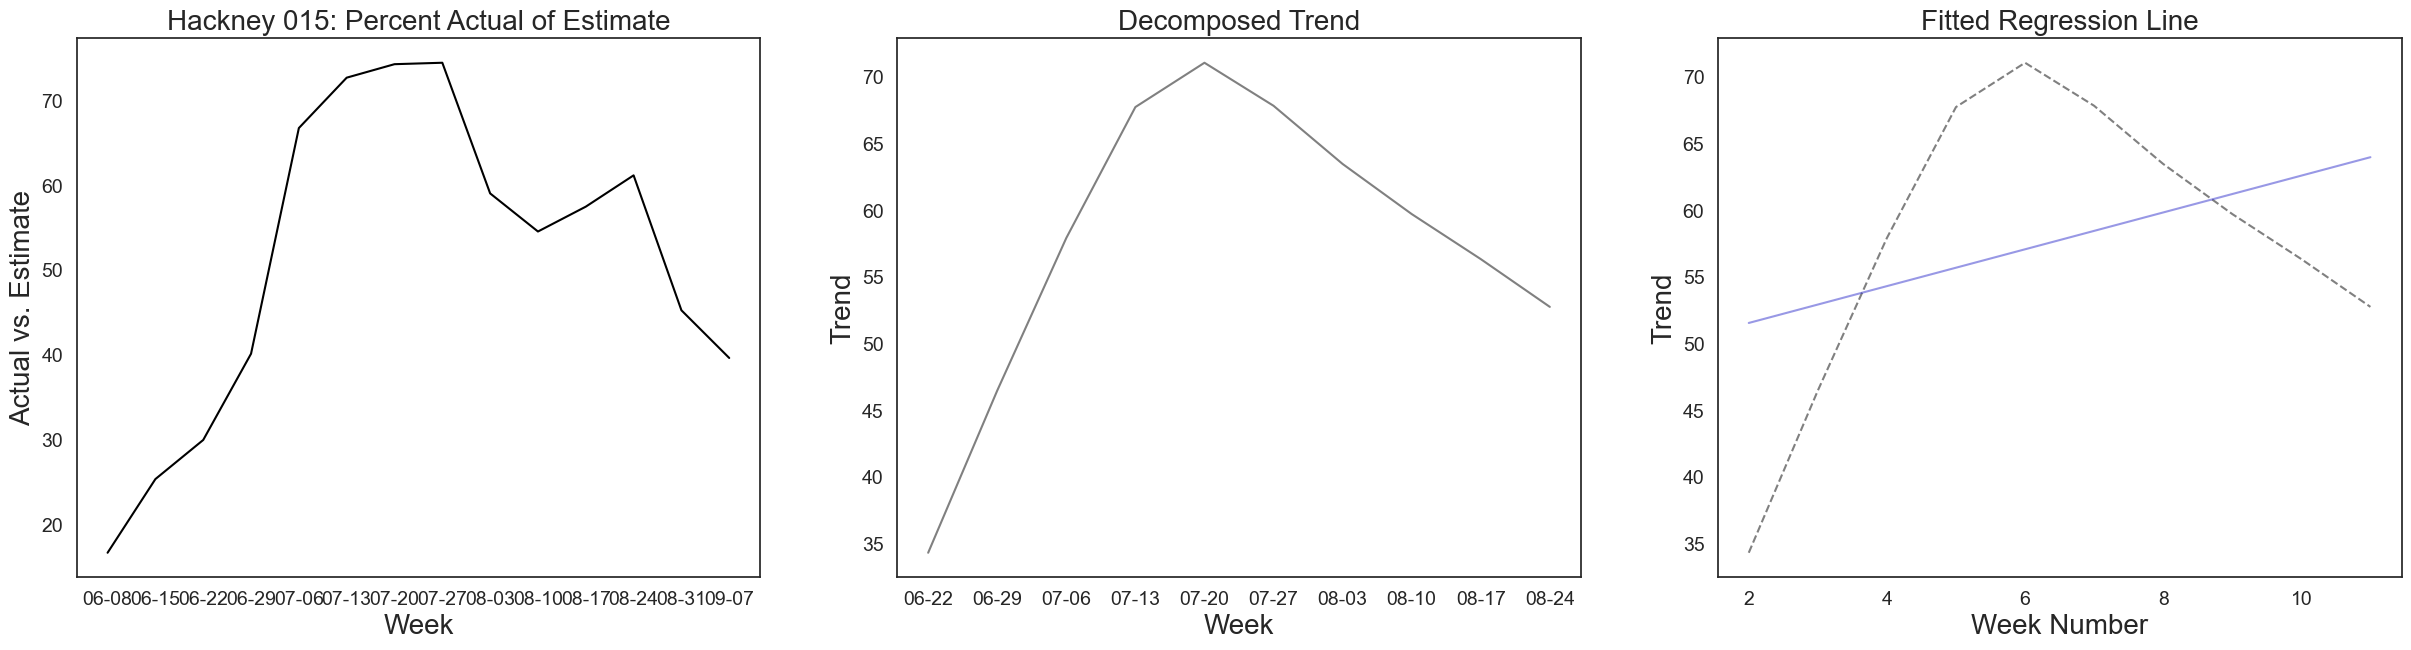

In [32]:
# Repeating above for Hackney 015
sns.set_context('notebook')

fig, ax = plt.subplots(1, 3, figsize=(30, 7), sharex=False, sharey=False)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers_final)]
df = df[df['msoa_name']=='Hackney 015']

df_sample = df[['week_beg', 'pct_diff']]
df_sample = df_sample.set_index('week_beg')
decomposition_sample = sm.tsa.seasonal_decompose(df_sample, model = 'additive', period = 4)
df_sample = df_sample.reset_index()
df_sample['week_beg'] = df_sample['week_beg'].dt.strftime('%m-%d')

df_sampletrend = decomposition_sample.trend
df_sampletrend = pd.DataFrame(decomposition_sample.trend[2:len(df_sample)-2])
df_sampletrend = df_sampletrend.reset_index()
df_sampletrend = df_sampletrend.merge(weeks_map, how = 'left', left_on = 'week_beg', right_on = 'week_beg')
df_sampletrend['week_beg'] = df_sampletrend['week_beg'].dt.strftime('%m-%d')
trend = np.array(df_sampletrend['trend'])
weeks = np.array(df_sampletrend['weeks'])

coefficients = np.polyfit(weeks, trend, 1)
print(coefficients)
poly = np.poly1d(coefficients)

new_x = np.linspace(weeks[0], weeks[-1])
new_y = poly(new_x)

df_regression = pd.DataFrame(new_x, new_y)
df_regression = df_regression.reset_index()
df_regression = df_regression.rename({0:'weeks'}, axis=1)

p = sns.lineplot(x='week_beg', y='pct_diff', data = df_sample, color = 'black', legend = False, ax=ax[0])#, palette = 'light:b', alpha=0.5)#, ax=ax[0])
q = sns.lineplot(x='week_beg', y='trend', data = df_sampletrend, color = 'grey', legend = False, ax=ax[1])
r = sns.lineplot(x='weeks', y='trend', data = df_sampletrend, color = 'grey', legend = False, ls='--', ax=ax[2])
s = sns.lineplot(x='weeks', y='index', data = df_regression, color = '#3333CC', legend = False, alpha = 0.5, ax=ax[2])

#fig.suptitle('Sample of how Resilience Measure is calculated', fontsize=15)

p.set_title("Hackney 015: Percent Actual of Estimate", fontsize = 20)
p.set_ylabel("Actual vs. Estimate", fontsize = 20)
p.set_xlabel("Week", fontsize = 20)


q.set_title("Decomposed Trend", fontsize = 20)
q.set_ylabel("Trend", fontsize = 20)
q.set_xlabel("Week", fontsize = 20)

r.set_title("Fitted Regression Line", fontsize = 20)
r.set_ylabel("Trend", fontsize = 20)
r.set_xlabel("Week Number", fontsize = 20)

for i in range(0,3):
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        label.set_fontsize(14)
        
plt.show()
plt.savefig('../figures/hackney_sample.png')

In [33]:
# Calculate weeks from the beginning of the lockdown, this is important for the slope estimates (cannot be against a datetime object)

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df['week_beg'].unique()
df = pd.DataFrame(df)
df.rename(columns = {0:'week_beg'}, inplace = True)

df['weeks'] = 0
df = df.sort_values(by=['week_beg'])

# For loop to calculate number of days in the analysis
for j in range(0, len(df)):
    if (j==0):
        df.iloc[j, len(df.columns)-1] = 0
    else:
        df.iloc[j, len(df.columns)-1] = df.iloc[j-1, len(df.columns)-1] + 1

weeks_map = df

In [34]:
# Code references:
# how to extract trend from decomposed model: https://mlforanalytics.com/2020/05/29/decomposing-time-series-financial-analytics/

pd.options.display.float_format = '{:,.4f}'.format

df = pt_msoaest
df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
df = df[~df['msoa_name'].isin(msoa_outliers_final)]
df = df.groupby(['region', 'subregion', 'msoa_name', 'msoa_code'])['week_beg'].count()
df = pd.DataFrame(df)
df = df.reset_index()
#df = df[df['week_beg']>24]
msoalist = df[['region', 'subregion', 'msoa_name', 'msoa_code']].drop_duplicates()
msoalist = np.array(msoalist)
#print(len(msoalist)-1)


df_slope = []
df_slope = pd.DataFrame(df_slope)
df_slope['region'] = 0
df_slope['subregion'] = 0
df_slope['msoa_name'] = 0
df_slope['msoa_code'] = 0
df_slope['slope'] = 0

df_decompose = []


# For loop to create a dataframe of every MSOA with it's corresponding slope
for i in range(0,len(msoalist)):
    #print(msoalist[i][2])
    # Create a dataframe for each local authority
    df = pt_msoaest[pt_msoaest['msoa_name']==msoalist[i][2]]
    df = df[(df['week_beg']>=start_wkbeg)&(df['week_beg']<=end_wkbeg)]
    df = df[['week_beg', 'pct_diff']]
    df = df.set_index('week_beg')
    # Decompose the trend of origin trips
    #decomposition = sm.tsa.seasonal_decompose(df, model = 'additive', extrapolate_trend = 'freq')
    decomposition = sm.tsa.seasonal_decompose(df, model = 'additive', period = 2)#int(len(df)/2))
    df_trend = pd.DataFrame(decomposition.trend[2:len(decomposition.trend)-2]) ## This is critical -- range without NaNs.
    df_trend = df_trend.reset_index()
    df_trend = df_trend.merge(weeks_map, how = 'left', left_on = 'week_beg', right_on = 'week_beg')
    # Create a dataframe of the trend
    # Calculate the slope of the trend
    trend = np.array(df_trend['trend'])
    weeks = np.array(df_trend['weeks'])
    slope,intercept = np.polyfit(weeks, trend, 1)
    # Store the local authority name and slope in a dataframe, total rows should be 33
    df_slope.loc[i,'region'] = msoalist[i][0]
    df_slope.loc[i,'subregion'] = msoalist[i][1]
    df_slope.loc[i,'msoa_name'] = msoalist[i][2]
    df_slope.loc[i,'msoa_code'] = msoalist[i][3]
    df_slope.loc[i,'slope'] = slope

#df_slope
slope_msoa = df_slope
#slope_msoa

#### Plotting of Spatial Resilience Measure
This section spatially plots the SRM, provides a histogram, and a boxplot of the SRM by region category.

In [35]:
# Get geometry back, include Local Authority columns.
df = slope_msoa
df = df.merge(msoas, left_on = ['msoa_code'], right_on = ['MSOA11CD'])
df = gpd.GeoDataFrame(df, crs = 'epsg:27700')
df = df.rename({'LAD11NM':'la_name', 'LAD11CD':'la_code'}, axis=1)
df = df[['region', 'subregion','msoa_name', 'msoa_code', 'slope', 'la_name', 'la_code', 'geometry']]

slope_msoa = df

<Figure size 640x480 with 0 Axes>

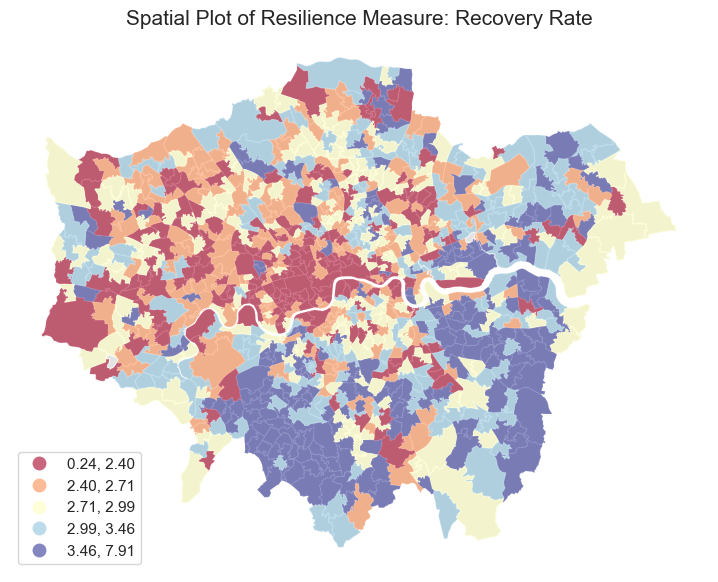

In [36]:
# Plot a chloropeth of slope, code inspired by https://geographicdata.science/book/notebooks/
# We expect to see Central London has the smallest slope -- least likely these areas will have travel demand due to WFH.

sns.set_context('notebook')

f, ax = plt.subplots(1, figsize=(12, 7))

df = slope_msoa

#tfl_cmap = ["#3333CC", "#7373FF", "#FF3333", "#FF7171", "#FF9B00"]
#tfl_cmap = sns.color_palette(tfl_cmap)

plotmsoa = msoas.plot(ax=ax,alpha=0.8,color='gainsboro')
plotslope = df.plot(column='slope', 
                       cmap='RdYlBu', #Pastel1
                       scheme='quantiles',
                       #k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.6, 
                       legend=True,
                       legend_kwds={'fmt':'{:.2f}',"loc": 3},
                       ax=ax
                      )

ax.set_axis_off()
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plotslope.set_title("Spatial Plot of Resilience Measure: Recovery Rate", fontsize = 15)
plt.show()
plt.savefig('../figures/spatial_recoveryrate.png')

In [37]:
sns.set_context('notebook')

df = slope_msoa

f, ax = plt.subplots(1, figsize=(12, 7))

p = sns.histplot(x='slope', data = df, color = '#3333CC')
p.set_title("Histogram of Recovery Rate", fontsize = 15)
plt.xlabel("Recovery Rate")
plt.savefig('../figures/histogram_recoveryrate.png')

In [38]:
pd.options.display.float_format = '{:,.2f}'.format
df = slope_msoa

df = df.groupby(['region']).describe()
df
#df.pivot(columns = 'slope')

slope                                   
        count mean  std  min  25%  50%  75%  max
region                                          
Inner  395.00 2.74 0.74 0.24 2.37 2.72 3.05 7.91
Outer  586.00 3.10 0.83 0.63 2.55 2.94 3.46 6.92

In [39]:
df = slope_msoa
df.describe()

,slope
count,981.00
mean,2.96
std,0.82
min,0.24
25%,2.48
50%,2.83
75%,3.30
max,7.91


In [40]:
# Distribution by region and subregion
sns.set_context('notebook')
f, ax = plt.subplots(1, figsize=(7, 5))
df = slope_msoa

#tfl_cmap = sns.diverging_palette(250, 10, n=9, as_cmap = True)
tfl_cmap = ["#3333CC", "#7373FF", "#FF3333", "#FF7171", "#FF9B00"]
sns.set_palette(sns.color_palette(tfl_cmap))
#tfl_cmap = {'Inner East': 'red', 'Inner West': 'light red', 'Outer East and North East': 'blue', 'Outer South': 'blue', 'Outer West and North West': 'blue'}

p = sns.boxplot(x='slope', y = 'region', data = df, hue = 'subregion')#, palette = tfl_cmap)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#sns.histplot(x='slope', data = df, hue = 'region')
p.set_title("Boxplot of Recovery Rate by Subregion", fontsize = 15)
plt.ylabel("Region")
plt.xlabel("Recovery Rate")

plt.savefig('../figures/boxplot_recoveryrate.png')

In [41]:
# Observng who has the highest slope
slope_msoa[slope_msoa['slope']>=7]

,region,subregion,msoa_name,msoa_code,slope,la_name,la_code,geometry
246,Inner,Inner East,Tower Hamlets 020,E02000883,7.91,Tower Hamlets,E09000030,"POLYGON ((537751.837 181672.988, 537771.827 18..."


In [42]:
# Name dataframe, validating 981 MSOAs are captured.
slope_msoa_jun = df
len(slope_msoa_jun.index)

981

In [43]:
# Save as Shape File
slope_msoa_jun.to_file('../output_data/slope_msoa_jun.shp')